Eda and preprocessing details in : https://github.com/saras108/Intern/blob/master/eda/loan_pass.ipynb

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad

from sklearn.metrics import accuracy_score

#datasets = https://www.kaggle.com/c/home-credit-default-risk/data
csv_dir = '../../loan_data'

In [2]:
data_train = pd.read_csv(os.path.join(csv_dir,'application_train.csv'))
data_test = pd.read_csv(os.path.join(csv_dir,'application_test.csv'))

index = data_test['SK_ID_CURR']



In [3]:
class Preprocessing():
    drop_selected_column = ['COMMONAREA_MEDI',
                        'COMMONAREA_MODE',
                        'NONLIVINGAPARTMENTS_MEDI',
                        'NONLIVINGAPARTMENTS_MODE',
                        'FONDKAPREMONT_MODE',
                        'LIVINGAPARTMENTS_MODE',
                        'LIVINGAPARTMENTS_MEDI',
                        'FLOORSMIN_MODE',
                        'FLOORSMIN_MEDI',
                        'YEARS_BUILD_MODE' ,
                         'YEARS_BUILD_MEDI',
                        'LANDAREA_MEDI',
                         'LANDAREA_MODE',
                        'BASEMENTAREA_MEDI',
                        'BASEMENTAREA_MODE',
                        'NONLIVINGAREA_MEDI',
                        'NONLIVINGAREA_MODE',
                        'ELEVATORS_MEDI',
                        'ELEVATORS_MODE',
                        'WALLSMATERIAL_MODE',
                        'AMT_GOODS_PRICE',
                        'APARTMENTS_MODE',
                        'APARTMENTS_MEDI',
                        'ENTRANCES_MODE',
                        'ENTRANCES_MEDI',
                        'LIVINGAREA_MEDI',
                        'LIVINGAREA_MODE',
                        'FLOORSMAX_MEDI',
                        'FLOORSMAX_MODE',
                        'YEARS_BEGINEXPLUATATION_MEDI',
                        'YEARS_BEGINEXPLUATATION_MODE',
                        'AMT_REQ_CREDIT_BUREAU_WEEK',
                        'AMT_REQ_CREDIT_BUREAU_DAY',
                        'AMT_REQ_CREDIT_BUREAU_MON',
                        'AMT_REQ_CREDIT_BUREAU_QRT',
                        'AMT_REQ_CREDIT_BUREAU_HOUR',
                        'OBS_30_CNT_SOCIAL_CIRCLE',
                        'DEF_30_CNT_SOCIAL_CIRCLE',
                        'OBS_60_CNT_SOCIAL_CIRCLE',
                        'DEF_60_CNT_SOCIAL_CIRCLE',
                        'SK_ID_CURR',
                        'AMT_REQ_CREDIT_BUREAU_YEAR', 
                        'FLAG_CONT_MOBILE',
                        'ORGANIZATION_TYPE' , 
                        'WEEKDAY_APPR_PROCESS_START',
                        'OCCUPATION_TYPE']
    
    def __init__(self , df ):
        self.df = df
               
    def drop_colm(self):
        for col in self.drop_selected_column:
            if col in self.df.columns:
#                 df = df.drop(columns=col, axis=1)
                self.df.drop(self.drop_selected_column , axis = 1, inplace = True)
        
    def get_docs_count(self):
        self.df['DOCS_COUNT'] = self.df.filter(regex = '^(FLAG_DOCUMENT)').sum(axis = 1)
        drop_these = self.df.filter(regex = '^(FLAG_DOCUMENT)').columns
        self.df.drop(drop_these , axis = 1, inplace = True)
        
    def impute_zero(self , col):
        for c in col:
            self.df[c] = self.df[c].fillna(0)

            
    def impute_mean(self , col):
        mean = self.df[col].mean()
        self.df[col] = self.df[col].fillna(mean)
        

    def impute_median(self , col):
        med = self.df[col].median()
        self.df[col] = self.df[col].fillna(med)

    def impute_mode(self, col):
        mode = self.df[col].mode()
        self.df[col] = self.df[col].fillna(mode[0])


    def car_data(self):
        car = pd.DataFrame()
        car['flag'] = self.df['FLAG_OWN_CAR']
        car['age'] = self.df['OWN_CAR_AGE']

        car[(car['flag'] == 0) &  (car['age']  > 0)] #shouls be empty

        a = car[(car['age']==0)  & (car['flag'] == 1)] #Should be empty else we will update age as 0.5

        select_row = a.index

        self.df.at[select_row,'OWN_CAR_AGE']=0.5

        self.df.drop(['FLAG_OWN_CAR'] , axis = 1, inplace = True)
        
    def eda(self):        
        self.drop_colm()
        self.get_docs_count()
        
        self.impute_zero( ['COMMONAREA_AVG', 'NAME_TYPE_SUITE' , 'NONLIVINGAPARTMENTS_AVG','LIVINGAPARTMENTS_AVG', 'FLOORSMIN_AVG' , 'YEARS_BUILD_AVG' , 'LANDAREA_AVG','BASEMENTAREA_AVG','NONLIVINGAREA_AVG','ELEVATORS_AVG','APARTMENTS_AVG','ENTRANCES_AVG','LIVINGAREA_AVG','HOUSETYPE_MODE','FLOORSMAX_AVG','YEARS_BEGINEXPLUATATION_AVG','TOTALAREA_MODE','EMERGENCYSTATE_MODE' , 'OWN_CAR_AGE'])
        self.df['HOUSETYPE_MODE']= self.df['HOUSETYPE_MODE'].map(str)
        self.df['EMERGENCYSTATE_MODE']= self.df['EMERGENCYSTATE_MODE'].map(str)
        
        self.df['DAYS_LAST_PHONE_CHANGE']=abs(self.df['DAYS_LAST_PHONE_CHANGE'])
        self.df['DAYS_REGISTRATION']=abs(self.df['DAYS_REGISTRATION'])
        self.df['DAYS_ID_PUBLISH']=abs(self.df['DAYS_ID_PUBLISH'])
        self.df['DAYS_EMPLOYED']=abs(self.df['DAYS_EMPLOYED'])

        self.impute_mean('EXT_SOURCE_1')
        self.impute_median( 'EXT_SOURCE_2')
        self.impute_median( 'EXT_SOURCE_3')
        self.impute_mean( 'AMT_ANNUITY')
        self.impute_median( 'CNT_FAM_MEMBERS')
        self.impute_mode( 'DAYS_LAST_PHONE_CHANGE')

        self.car_data()
      
        newflags = {
            'No' : 0,
            'Yes' : 1,
            '0' :0,
        }
        self.df.EMERGENCYSTATE_MODE = [newflags[item] for item in self.df.EMERGENCYSTATE_MODE]

        newflags = {
            'Working' : 2 ,
            'Commercial associate' : 3,
            'Businessman' : 3,
            'Pensioner' : 1,
            'State servant' : 4,
            'Unemployed' : 0,
            'Student' : 0,
            'Maternity leave' : 1,
        }
        self.df.NAME_INCOME_TYPE = [newflags[item] for item in self.df.NAME_INCOME_TYPE]

        newflags = {
            'Secondary / secondary special' : 0 ,
            'Higher education' : 1,
            'Incomplete higher' : 2,
            'Lower secondary' : 3,
            'Academic degree' : 4
        }
        self.df.NAME_EDUCATION_TYPE = [newflags[item] for item in self.df.NAME_EDUCATION_TYPE]


        newflags = {
            'block of flats' : 0 ,
            'specific housing' : 1,
            'terraced house' : 1,
            '0': 0
        }
        self.df.HOUSETYPE_MODE = [newflags[item] for item in self.df.HOUSETYPE_MODE]
        
        
        newflags = {
            'F' : 0,
            'M' : 1,
            'XNA' : 0,
    
        }
        self.df.CODE_GENDER = [newflags[item] for item in self.df.CODE_GENDER]



        newflags = {
                    'Unaccompanied' : 0,
                    'Family' : 1,
                    'Spouse, partner' : 1,
                    'Children' : 1,
                    'Other_B' : 0,
                    'Other_A': 0,
                    'Group of people': 0,    
                    0: 0
                }
        self.df.NAME_TYPE_SUITE = [newflags[item] for item in self.df.NAME_TYPE_SUITE]



        newflags = {
                    'House / apartment' : 1,
                    'With parents' : 0,
                    'Municipal apartment' : 1,
                    'Rented apartment' : 1,
                    'Office apartment' : 1,
                    'Co-op apartment': 1,

                }
        self.df.NAME_HOUSING_TYPE = [newflags[item] for item in self.df.NAME_HOUSING_TYPE]




        newflags = {
                    'Married' : 1,
                    'Single / not married' : 0,
                    'Civil marriage' : 1,
                    'Widow' : 0,
                    'Unknown' : 0,
                    'Separated': 0,

                }
        self.df.NAME_FAMILY_STATUS = [newflags[item] for item in self.df.NAME_FAMILY_STATUS]



        self.df = pd.get_dummies(self.df, columns=['NAME_CONTRACT_TYPE'], drop_first=True,  prefix='CONTRACT',)
        self.df = pd.get_dummies(self.df, columns=['FLAG_OWN_REALTY'], drop_first=True,  prefix='REALITY',)


            
        return self.df


    
    def process(self):
        
        droput=nn.Dropout(.4)
        
        cata_feature = []
        for i in self.df.columns:
            if(len(self.df[i].unique()) < 15):
                cata_feature.append(i)
                
        cont_features=[]
        for i in self.df.columns:
            if i in cata_feature:
                pass
            else:
                cont_features.append(i)
        
        lbl_encoder = {}
        for feature in cata_feature:
            lbl_encoder[feature] = LabelEncoder()
            self.df[feature] = lbl_encoder[feature].fit_transform(self.df[feature])
            
        cata_tensor=np.stack([self.df[i].values for i in cata_feature],axis=1)
        cata_tensor=torch.tensor(cata_tensor,dtype=torch.int64)
        
        
        cont_tensor=np.stack([self.df[i].values for i in cont_features],axis=1)
        cont_tensor=torch.tensor(cont_tensor,dtype=torch.float)
        
        #### Embedding Size For Categorical columns
        cat_dims=[len(self.df[col].unique()) for col in cata_feature]
        embedding_dim= [(x, min(50, (x + 1) // 2)) for x in cat_dims]
        
        embedding_val=[]
        for i,e in enumerate(nn.ModuleList([nn.Embedding(inp,out) for inp,out in embedding_dim])):
            embedding_val.append(e(cata_tensor[:,i]))

        cat_data = torch.cat(embedding_val, 1)
        final_embed=droput(cat_data)
        
        X = torch.cat((final_embed, cont_tensor), 1)
        X = torch.FloatTensor(X)
        
        return X

In [4]:
# Creating model with pytorch

class ANN_Model(nn.Module):
    def __init__(self , input_feature =55 , hidden1 =20 , hidden2 =11, out_feature =2):
        super().__init__()
        self.f_connected1 = nn.Linear(input_feature , hidden1)
        self.f_connected2 = nn.Linear(hidden1 , hidden2)
        self.out  = nn.Linear(hidden2, out_feature)
    
    def forward(self, x):
        x = F.sigmoid(self.f_connected1(x))
        x = F.leaky_relu(self.f_connected2(x))
        x =self.out(x)
        
        return x

torch.manual_seed(20)
model = ANN_Model()

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters() , lr=0.01)

In [5]:
preprocessing = Preprocessing(data_train)
data = preprocessing.eda()

from imblearn.under_sampling import RandomUnderSampler
X = data.drop('TARGET' , axis =1)
y = data['TARGET']

# print(X.shape)

under = RandomUnderSampler(sampling_strategy='majority')
X , y = under.fit_resample(X, y)


X = torch.FloatTensor(X.values)
y = torch.LongTensor(y.values)

In [6]:
epochs = 100

final_losses = []

for i in range(epochs):
    
    i=i+1
    y_pred = model.forward(X)
    
    loss = loss_function(y_pred , y)
    
    final_losses.append(loss)
    
    print("Epoc {} and Loss {}".format(i , loss.item()))
    
    loss.backward(retain_graph=True)
    
    optimizer.step()
        
    optimizer.zero_grad()

C:\Users\Dell\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoc 1 and Loss 0.70622318983078
Epoc 2 and Loss 0.7003055810928345
Epoc 3 and Loss 0.6953856945037842
Epoc 4 and Loss 0.6935923099517822
Epoc 5 and Loss 0.694827139377594
Epoc 6 and Loss 0.6945477724075317
Epoc 7 and Loss 0.6932403445243835
Epoc 8 and Loss 0.6922363042831421
Epoc 9 and Loss 0.6921941041946411
Epoc 10 and Loss 0.692357063293457
Epoc 11 and Loss 0.6919481754302979
Epoc 12 and Loss 0.6913952231407166
Epoc 13 and Loss 0.6908250451087952
Epoc 14 and Loss 0.6901029944419861
Epoc 15 and Loss 0.6897051930427551
Epoc 16 and Loss 0.6896340847015381
Epoc 17 and Loss 0.6895663142204285
Epoc 18 and Loss 0.6893417835235596
Epoc 19 and Loss 0.6894189715385437
Epoc 20 and Loss 0.6895588636398315
Epoc 21 and Loss 0.6897127628326416
Epoc 22 and Loss 0.6897637248039246
Epoc 23 and Loss 0.6895062327384949
Epoc 24 and Loss 0.6894327402114868
Epoc 25 and Loss 0.689510703086853
Epoc 26 and Loss 0.6895996928215027
Epoc 27 and Loss 0.6896156668663025
Epoc 28 and Loss 0.6897535920143127
Epoc 2

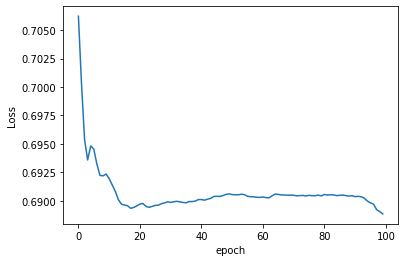

In [7]:
plt.plot(range(epochs), final_losses)
plt.ylabel('Loss')
plt.xlabel('epoch');

In [8]:
y_pred

tensor([[0.4193, 0.0917],
        [0.4193, 0.0917],
        [0.4193, 0.0917],
        ...,
        [0.1185, 0.1981],
        [0.1185, 0.1981],
        [0.1185, 0.1981]], grad_fn=<AddmmBackward>)

In [9]:
max_prob = torch.argmax(y_pred , dim = 1)

In [10]:
from sklearn.metrics import confusion_matrix, classification_report

In [11]:
confusion_matrix(max_prob, y)

array([[ 5535,  3846],
       [19290, 20979]], dtype=int64)

In [12]:
preprocessing = Preprocessing(data_test)
data = preprocessing.eda()

X = torch.FloatTensor(data.values)

In [13]:
y_pred = model.forward(X)
pred = torch.argmax(y_pred , dim = 1)

C:\Users\Dell\anaconda3\lib\site-packages\torch\nn\functional.py:1805: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [14]:
test_result = pd.DataFrame()
test_result['SK_ID_CURR'] = index
test_result['TARGET'] = pred = pred.numpy()

test_result.to_csv('ann_result.csv',index=False)